# Theta phase detection and theta power computation
We will first need to generate analytic signals from the LFP data, which depends on the LFPBand table, the parameters/filter and the time interval used for the signal transform. We will need `AnalyticSignalParameters`, `AnalyticSignalSelection`, and `AnalyticSignal` to be populated accordingly. Then we can use the functions built into the analytic signal object to compute signal phase and power. Let's import the LFPBand and analytic_signal tables:

In [1]:
import os
from spyglass.lfp.v1 import LFPBand, LFPElectrodeGroup
from spyglass.lfp.v1.analytic_signal import *
import matplotlib.pyplot as plt

Please enter DataJoint username:  xulu


[2023-05-17 17:32:32,555][INFO]: Connecting xulu@lmf-db.cin.ucsf.edu:3306
[2023-05-17 17:32:32,604][INFO]: Connected xulu@lmf-db.cin.ucsf.edu:3306
/home/lorenlab/anaconda3/envs/spyglass/lib/python3.9/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


#### First, insert parameters for theta phase detection. 
Currently we only use Hilbert transform for this step so that is a fixed parameter for now. So we will only need to insert the default parameters. In the future if anyone is interested in using a different signal tranform method, they could insert a self-defined parameter set into the AnalyticSignalParameters table.

In [6]:
AnalyticSignalParameters().insert_default()
AnalyticSignalParameters()

analytic_signal_params_name name of the parameter set for detecting analytic signals,"analytic_signal_params a dict of analytic-signal detection parameters(the method name, e.g., hilbert transform, and specific parameters if any)"
default,=BLOB=


We can take a look at the parameter dictionary (for Hilbert tranform, there's no additional parameters than the method name itself):

In [4]:
params = (
    AnalyticSignalParameters() & {"analytic_signal_params_name": "default"}
).fetch1("analytic_signal_params")
print(params)

{'analytic_method_name': 'Hilbert transform', 'other_params': ''}


In [5]:
# lfp_key will be used to select theta data from the LFPBand table.
nwb_file_name = "j1620210710_.nwb"
lfp_key = dict()
lfp_key["nwb_file_name"] = nwb_file_name
lfp_key["filter_name"] = "Theta 5-11 Hz"
# Use the same interval list name as in the LFPBand entry of interest; here for simplicity, we'll use a test interval
lfp_key["target_inteval_list_name"] = "test interval"

#### Next, insert entries into the AnalyticSignalSelection table.
Because we do not need all electrodes for detecting theta phase/power, we need to define a specific electrode group for it.

In [ ]:
group_name = "theta_phase"
electrode_list = [
    0,
    40,
]  # This should be the hippocampal reference eletrode ids because we usually use them to determine theta phase and power.
LFPElectrodeGroup().create_lfp_electrode_group(
    nwb_file_name, group_name, electrode_list
)

Check that the electrode group for our analysis purpose has been successfully inserted (one also need to make sure that the LFPBand data for these electrodes already exist; if not, go to the LFP tutorial to generate them).

In [8]:
LFPElectrodeGroup & {
    "nwb_file_name": nwb_file_name,
    "lfp_electrode_group_name": group_name,
}

nwb_file_name name of the NWB file,lfp_electrode_group_name
j1620210710_.nwb,theta_phase


In [9]:
tph_key = (LFPBand & lfp_key).fetch1("KEY")
tph_key["analytic_signal_params_name"] = "default"
# The following interval list name is what we'll use for theta phase detection;
# it needs to be already existing in the LFPBand data and also the IntervalList() table.
tph_key["interval_list_name"] = (LFPBand & lfp_key).fetch1("interval_list_name")
tph_key["lfp_electrode_group_name"] = "theta_phase"
AnalyticSignalSelection().insert1(tph_key, skip_duplicates=True)
AnalyticSignalSelection()

lfp_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,interval_list_name descriptive name of this interval list,lfp_electrode_group_name,analytic_signal_params_name name of the parameter set for detecting analytic signals
81cbe85a-f06c-11ed-a02d-04d9f580fe36,Theta 5-11 Hz,1000,j1620210710_.nwb,test interval,1000,test interval lfp band 1000Hz,theta_phase,default


#### Lastly, populate the AnalyticSignal table which will store the LFPBand data post hilbert transform.

In [10]:
# The new entry to be added to the AnalyticSignal table shouldn't exist yet before populating.
AnalyticSignal() & tph_key

lfp_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,interval_list_name descriptive name of this interval list,lfp_electrode_group_name,analytic_signal_params_name name of the parameter set for detecting analytic signals,analysis_file_name name of the file,analytic_signal_object_id the NWB object ID for loading this object from the file


In [11]:
# Populate the analytic signal table with the new entry.
AnalyticSignal().populate((AnalyticSignalSelection() & tph_key).proj())

/home/lorenlab/anaconda3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/lorenlab/anaconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (55098, 4) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/lorenlab/anaconda3/envs/spyglass/lib/python3.9/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (44198, 4) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape

Writing new NWB file j1620210710_I9FIPQKNIB.nwb

Populated analytic signal table for nwb_file_name=j1620210710_.nwb between 1625935702.6159332ms and 1625935802.6137688ms


/home/lorenlab/anaconda3/envs/spyglass/lib/python3.9/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


In [12]:
# Check that the analytic signal table is successfully populated by the new results.
AnalyticSignal() & tph_key

lfp_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,interval_list_name descriptive name of this interval list,lfp_electrode_group_name,analytic_signal_params_name name of the parameter set for detecting analytic signals,analysis_file_name name of the file,analytic_signal_object_id the NWB object ID for loading this object from the file
81cbe85a-f06c-11ed-a02d-04d9f580fe36,Theta 5-11 Hz,1000,j1620210710_.nwb,test interval,1000,test interval lfp band 1000Hz,theta_phase,default,j1620210710_I9FIPQKNIB.nwb,a5be0d4e-9497-4d56-9419-bebf09b30aab


#### Let's take a look at the populated analytic signal data.
In the loaded results, the first column is the time stamps, and the other columns are the analytic sinals of theta band (complex numbers) for all electrodes that were included in the LFPBand data.

In [13]:
# Fetch the theta analytic signal.
theta_analytic_results = (AnalyticSignal & tph_key).fetch1_dataframe()

theta_analytic_results

,time stamps,electrode 0,electrode 40
id,,,
0,1.625936e+09,-8.00000+0113.958580j,-28.000000+127.578749j
1,1.625936e+09,-12.000000+84.275575j,-33.000000+94.369967j
2,1.625936e+09,-15.000000+86.760325j,-37.000000+96.216452j
3,1.625936e+09,-19.000000+78.099686j,-42.000000+85.408355j
4,1.625936e+09,-23.000000+79.717213j,-46.000000+85.895887j
...,...,...,...
99994,1.625936e+09,49.000000+54.115342j,35.000000+64.803958j
99995,1.625936e+09,48.000000+56.641484j,34.000000+67.018773j
99996,1.625936e+09,48.000000+69.764801j,33.000000+81.095129j


#### We can use the analytic signal table to compute theta phase and power for one example electrode

In [14]:
electrode_id = 0  # define which electrode we want to use for the analysis.
theta_phase = (AnalyticSignal & tph_key).compute_signal_phase(electrode_id)
theta_power = (AnalyticSignal & tph_key).compute_signal_power(electrode_id)

In [15]:
# Get theta band data that will be jointly plotted with the theta phase results.
theta_band = (LFPBand() & lfp_key).fetch_nwb()[0]["filtered_data"]
theta_band_sub = theta_band.data[
    np.logical_and(
        theta_band.timestamps >= theta_analytic_results["time stamps"].iloc[0],
        theta_band.timestamps <= theta_analytic_results["time stamps"].iloc[-1],
    )
]

#### Plot the data: overlay theta and detected phase for one example lfp electrode.
Note that the red horizontal line indicates phase 0 (corresponding to the trough of theta)

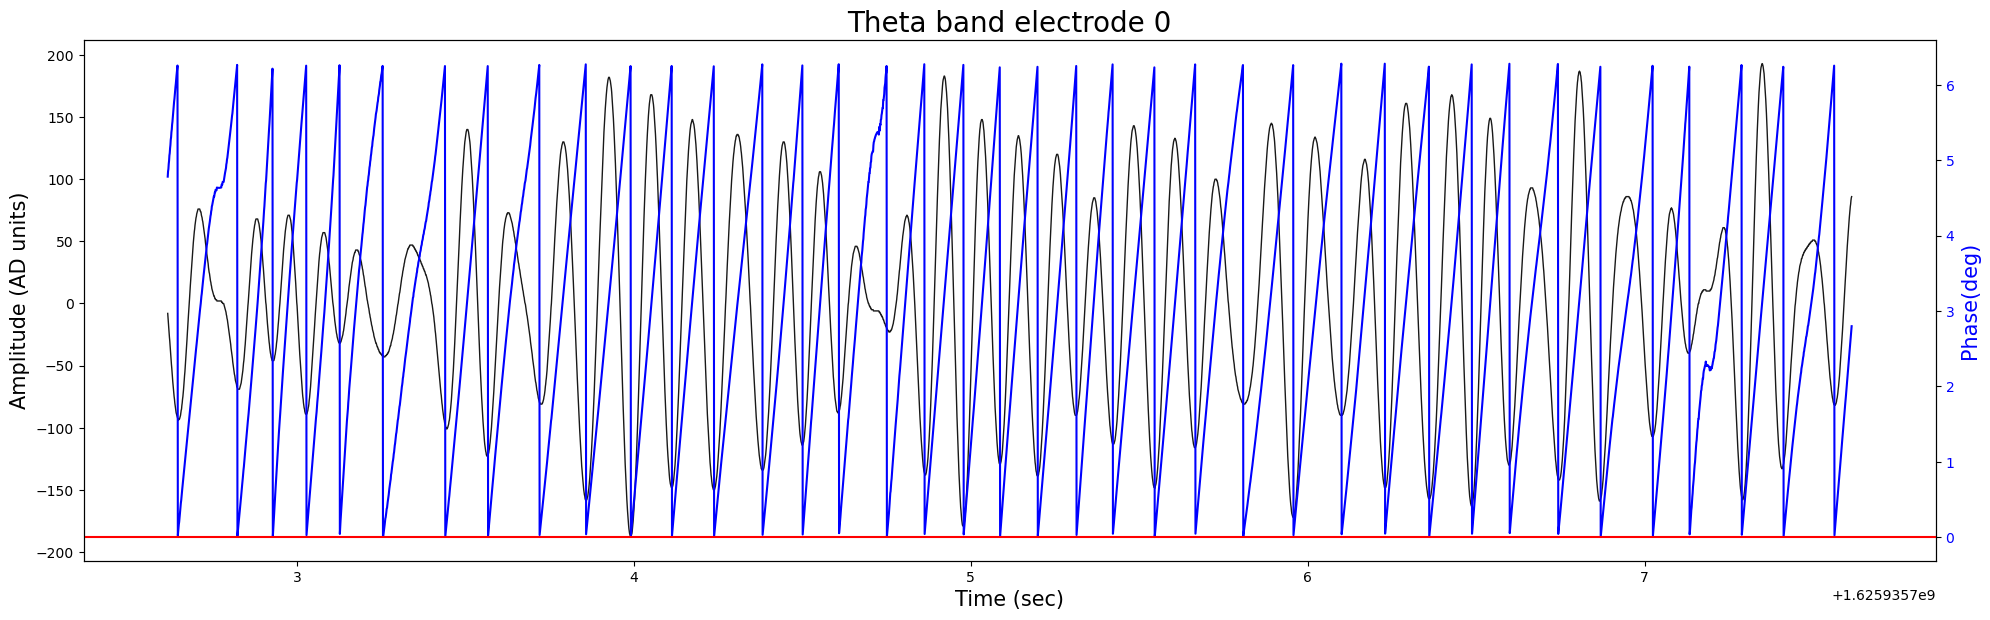

In [16]:
plot_start = 0  # the start time of plotting
plot_end = 5000  # the end time of plotting
fig, ax1 = plt.subplots(figsize=(20, 6))
ax1.set_xlabel("Time (sec)", fontsize=15)
electrode_index = (
    theta_analytic_results.columns.get_loc("electrode {0}".format(electrode_id)) - 1
)  # Map the eletrode id as in theta_analytic_results to the column number of theta_band
ax1.set_ylabel("Amplitude (AD units)", fontsize=15)
ax1.plot(
    theta_analytic_results["time stamps"].iloc[plot_start:plot_end],
    theta_band_sub[plot_start:plot_end, electrode_index],
    "k-",
    linewidth=1,
    alpha=0.9,
)
ax1.tick_params(axis="y", labelcolor="k")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("Phase(deg)", color="b", fontsize=15)
ax2.plot(
    theta_analytic_results["time stamps"].iloc[plot_start:plot_end],
    theta_phase[plot_start:plot_end],
    "b",
)
ax2.tick_params(axis="y", labelcolor="b")
ax2.axhline(y=0, color="r", linestyle="-")
fig.tight_layout()
ax1.set_title(
    "Theta band {0}".format(theta_analytic_results.columns[electrode_index + 1]),
    fontsize=20,
);

#### We can also plot the theta power if interested.

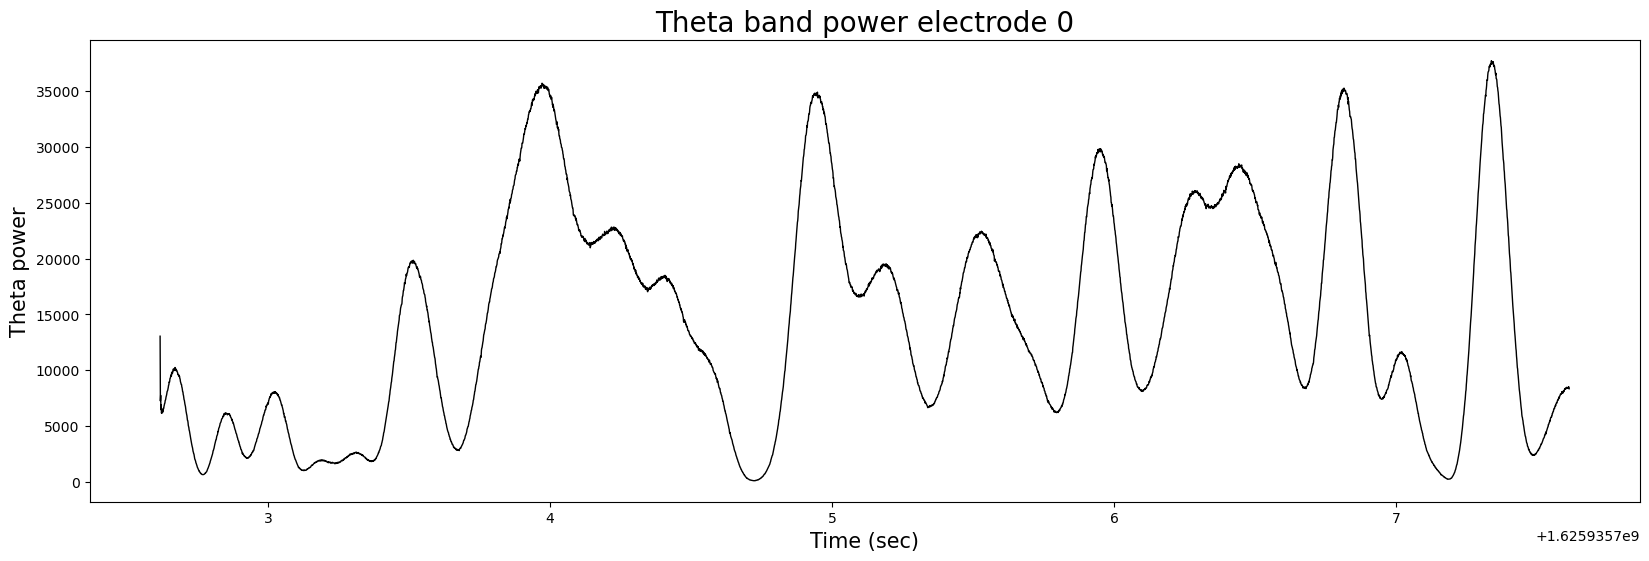

In [17]:
plot_start = 0  # the start time of plotting
plot_end = 5000  # the end time of plotting
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_xlabel("Time (sec)", fontsize=15)
electrode_index = (
    theta_analytic_results.columns.get_loc("electrode {0}".format(electrode_id)) - 1
)  # Map the eletrode id as in theta_analytic_results to the column number of theta_band
ax.set_ylabel("Theta power", fontsize=15)
ax.plot(
    theta_analytic_results["time stamps"].iloc[plot_start:plot_end],
    theta_power[plot_start:plot_end],
    "k-",
    linewidth=1,
)
ax.tick_params(axis="y", labelcolor="k")
ax.set_title(
    "Theta band power {0}".format(theta_analytic_results.columns[electrode_index + 1]),
    fontsize=20,
);